#  Generating a pipeline for microscopy data

In [1]:
# Standard dependencies
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob

# Custom written modules
import mwc_induction_utils as mwc

# Image processing functions
import skimage.io
import skimage.filters
import skimage.morphology
import skimage.segmentation
import scipy.ndimage

# For parallelization of arduous median filtering operations
import joblib as jlb

# Set the plotting environment.
%matplotlib notebook
sns.set_context('notebook')
sns.set_style('dark')
mwc.set_plotting_style()

/Users/gchure/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Thus far, all data has been collected on a MiltenyiBiotec MACSQuant flow cytometer. While this provides an incredibly high throughput method for making single-cell measurments, much information is lost as each cell only gives two real values -- scattering and integrated intensity. As all previous work in the lab has been performed using quantitative microscopy, we have taken a few measurements using a high-sensitivity laser illumination epifluorescence microscope. To make processing and analysis of microscopy data simpler, we need to develop a pipeline to extract fold change measurements from images.

###  Generating a flat-field image

Our microscopy set up is a Nikon TI-Eclipse inverted epifluoresence microscope outfitted with YFP (520nm) and TRITC (650nm **confirm this**) laser lines. The emission filters are designed for on-peak emission of YFP and have a remarkably flat dichroic mirror. The TRITC cube is designed for Hg lamp excitation, but works well for our laser system as well. Since we are not extracting quantitative information from the TRITC channel and are only using it for segmentation, this will not be an issue. 

However, we must correct for uneven illumination in the YFP channel since this happens to be the channel from which we would like to extract mean fluorescence values from. Our laser path results in an uneven illumination across the field of view during YFP excitation taking the shape of a two dimensional gaussian. This means that cells that happen to be closer to the edge of the field of view will be dimmer than those in the center. To correct for this, we correct each individual image such that it is flat in illumination across the entire sample. To perform this correction, we image a plastic fluorescence slide (Autofluorescent Plastic Slides, Chroma cat. no. 92001) in the YFP channel approximately 20 times and create an average intensity image. This gives an average image of the excitation illumination pattern. We then correct for uneven illumination by renormalizing each image as 

$$
\begin{align}
I_\mathrm{norm} = \frac{I - I_\mathrm{dark}}{I_\mathrm{field} - I_\mathrm{dark}}\mathrm{mean}(I_\mathrm{field} - I_\mathrm{dark})
\end{align}
$$

in which $I_\mathrm{norm}$ is the flat-field corrected image, $I_\mathrm{field}$ is teh average image of the illumination field and $I_\mathrm{dark}$ is an average image with no illumination and represents the camera shot noise. Prior to this correction, each image is median filtered with a 3x3 square structuring element to help correct for signal noise. We define the functions used for this correction below. 


In [2]:
def average_stack(im, median_filt=True):
    """
    Computes an average image from a provided array of images.

    Parameters
    ----------
    im : list or arrays of 2d-arrays
        Stack of images to be filtered.
    median_filt : bool
        If True, each image will be median filtered before averaging.
        Median filtering is performed using a 5x5 square structural element.

    Returns
    -------
    im_avg : 2d-array
        averaged image with a type of int.
    """


    # Determine if the images should be median filtered.
    if median_filt is True:
        selem = skimage.morphology.square(3)
        im_filt = [scipy.ndimage.median_filter(i, footprint=selem) for i in im]
        
    else:
        im = im_filt

    # Generate and empty image to store the averaged image.
    im_avg = np.zeros_like(im[0]).astype(int)
    for i in im:
        im_avg += i
    im_avg = im_avg / len(im)
    return im_avg

def generate_flatfield(im, im_dark, im_field, median_filt=True):
    """
    Corrects illumination of a given image using a dark image and an image of
    the flat illumination.

    Parameters
    ----------
    im : 2d-array
        Image to be flattened.
    im_dark : 2d-array
        Average image of camera shot noise (no illumination).
    im_field: 2d-array
        Average image of fluorescence illumination.
    median_filt : bool
        If True, the image to be corrected will be median filtered with a
        3x3 square structural element. 
        
    Returns
    -------
    im_flat : 2d-array
        Image corrected for uneven fluorescence illumination. This is performed
        as

        im_flat = ((im - im_dark) / (im_field - im_dark)) *
                   mean(im_field - im_dark)

    Raises
    ------
    RuntimeError
        Thrown if bright image and dark image are approximately equal. This
        will result in a division by zero.
    """

    # Ensure that the same image is not being provided as the bright and dark.
    if np.isclose(im_field, im_dark).all():
        raise RuntimeError('im_bright and im_dark are approximately equal.')
        
    # Compute the mean difference between the bright and dark image.
    mean_diff = np.mean(im_field - im_dark)
    
    if median_filt == True:
        selem = skimage.morphology.square(3) 
        im_filt = scipy.ndimage.median_filter(im, footprint=selem)
    else:
        im_filt = im

    # Compute and return the flattened image.
    im_flat = ((im_filt - im_dark) / (im_field - im_dark)) * mean_diff
    return im_flat


Let's try this functions out on some actual microscopy images.

In [3]:
# Define the data directory 
data_dir = '/Users/gchure/Desktop/20161018/'

# Load the dark and field images. 
dark_glob = glob.glob(data_dir + '*camera_noise*/*tif')
field_glob = glob.glob(data_dir + '*YFP_profile*/*tif')
dark_ims = skimage.io.ImageCollection(dark_glob, conserve_memory=False)
field_ims = skimage.io.ImageCollection(field_glob, conserve_memory=False)

We can begin by looking at a representative image of the field and dark images.

<IPython.core.display.Javascript object>


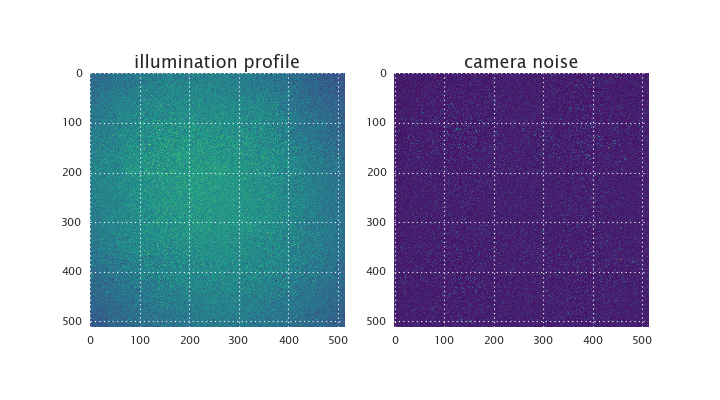

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(9, 5))
ax[0].imshow(field_ims[0], cmap=plt.cm.viridis)
ax[0].set_title('illumination profile', fontsize=16)
ax[1].imshow(dark_ims[0], cmap=plt.cm.viridis)
ax[1].set_title('camera noise', fontsize=16)

We can see that the pixel values certainly do appear to be higher in the middle of the illumination profile while there is a bunch of shot noise in the camera image. We will now generage average images of each. 

/Users/gchure/anaconda/lib/python3.4/site-packages/skimage/external/tifffile/tifffile.py:1106: UserWarning: ome-xml: not an ome-tiff master file
  warnings.warn("ome-xml: not an ome-tiff master file")


<IPython.core.display.Javascript object>


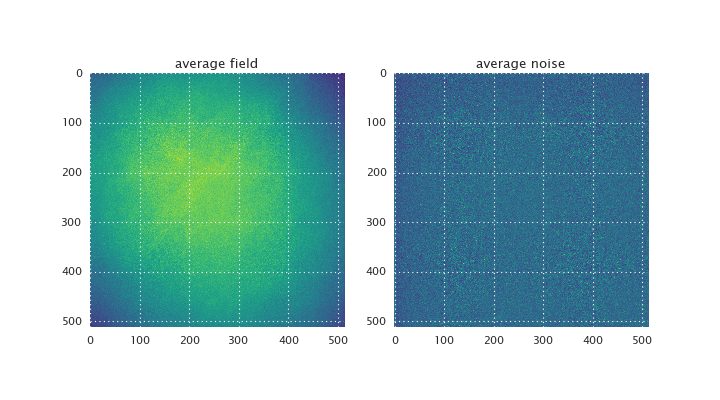

In [5]:
# Generate average images.
average_field = average_stack(field_ims)
average_dark = average_stack(dark_ims)

# Plot each average image. 
fig, ax = plt.subplots(1, 2, figsize=(9, 5))
ax[0].imshow(average_field, cmap=plt.cm.viridis)
ax[0].set_title('average field')
ax[1].imshow(average_dark, cmap=plt.cm.viridis)
ax[1].set_title('average noise')

Now that we have generated the average illumination profile and the average noise pattern, we can correct one of our images as an example. 

In [7]:
def ome_split(im):
    """Splits an ome.tiff image into individual channels"""
    if len(np.shape(im)) == 2:
        raise RuntimeError('provided image is a single channel')
    ims = []
    for i in range(np.shape(im)[-1]):
        ims.append(im[:, :, i])
    return ims

<IPython.core.display.Javascript object>


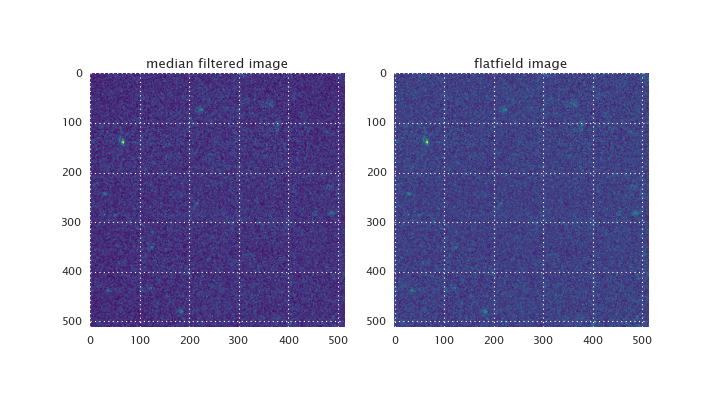

In [13]:
# Load an example image.
im = glob.glob(data_dir + '20161018_wt_O2_auto_50uMIPTG_1/*tif')
ex_im = skimage.io.imread(im[0])
phase, rfp_im, yfp_im =  ome_split(ex_im)

# Correct for uneven illumination.
selem = skimage.morphology.square(3)
yfp_filt = scipy.ndimage.median_filter(yfp_im, footprint=selem)
yfp_flat = generate_flatfield(yfp_filt, average_dark, average_field,
                              median_filt=False)


# Show both.
fig, ax = plt.subplots(1, 2, figsize=(9, 5))
ax[0].imshow(yfp_filt, cmap=plt.cm.viridis)
ax[0].set_title('median filtered image')
ax[1].imshow(yfp_flat, cmap=plt.cm.viridis)
ax[1].set_title('flatfield image')

We can prove that this corrects the uneven illumination by taking a profile across each dimension of the image before and after filtering.

<IPython.core.display.Javascript object>


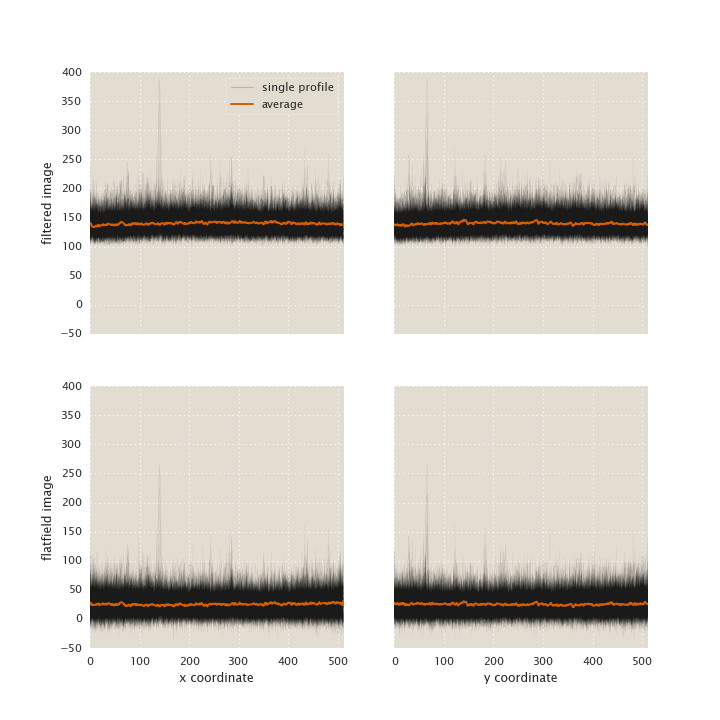

In [14]:
# Plot the profile and compute the average for the filtered and unfiltered case.
fig, ax = plt.subplots(2, 2, figsize=(9, 9), sharex=True, sharey=True)
avg_prof_x = []
avg_prof_y = []
im_shape = np.shape(yfp_filt)
x_range = np.arange(0, im_shape[1], 1)
y_range = np.arange(0, im_shape[0], 1)

# Generate averages
filt_avg_y, flat_avg_y = [], []
filt_avg_x, flat_avg_x = [], []
for i in range(im_shape[0]):
    filt_avg_y.append(np.mean(yfp_filt[i, :]))
    flat_avg_y.append(np.mean(yfp_flat[i, :]))
    ax[0, 1].plot(y_range, yfp_filt[i, :], 'k-', linewidth=0.1, alpha=0.2)
    ax[1, 1].plot(y_range, yfp_flat[i, :], 'k-', linewidth=0.1, alpha=0.2)
for i in range(im_shape[1]):
    filt_avg_x.append(np.mean(yfp_filt[:, i]))
    flat_avg_x.append(np.mean(yfp_flat[:, i]))
    if i == 1:
        ax[0, 0].plot(x_range, yfp_filt[:, i], 'k-',
                      linewidth=1, alpha=0.2, label='single profile')
    else:
        ax[0, 0].plot(x_range, yfp_filt[:, i], 'k-', linewidth=0.1, alpha=0.2)
    ax[1, 0].plot(x_range, yfp_flat[:, i], 'k-', linewidth=0.1, alpha=0.2)
    
# Now plot the averages over each.
ax[0, 0].plot(x_range, filt_avg_x, 'r-', label='average')
ax[0, 0].legend(loc='upper right')
ax[0, 1].plot(y_range, filt_avg_y, 'r-')
ax[1, 0].plot(x_range, flat_avg_x, 'r-')
ax[1, 1].plot(x_range, flat_avg_y, 'r-')

# Label things so we know what is what
ax[0, 0].set_ylabel('filtered image')
ax[1, 0].set_ylabel('flatfield image')
ax[1, 0].set_xlabel('x coordinate')
ax[1, 1].set_xlabel('y coordinate')

axes = ax.ravel()
for a in axes:
    a.set_xlim([0, 512])

The effect is subtle, but it is important to correct for when making quantitative fluorescence measurements from images.

###  Segmentation

To make segmentation of the bacterial cells much easier, we performed all experiments with cells containing a pZS4\*5 plasmid which constitutively expresses mCherry. As we knoew we would want to compare miccroscopy and flow-cytometry methods, we used this same construct for all flow measurments.

To segment in the fluorescence channel, we use the [Marr-Hildreth algorithm](http://rspb.royalsocietypublishing.org/content/207/1167/187)(also known as the Laplacian of Gaussian) for edge detection. We invite the interested reader to see the original paper by Marr and Hildreth for a detailed explanation of the algorthim, but it can be summarized as follows. 

1. Apply a Gaussian blur with a small $\sigma$ on the image. 
2. Compute the spatial second derivatives of the image using the Laplacian operator.
3. Identify regions in which the values of the second derivative cross zero. Each region is specified by a small structural element. These regions are the object edges.



In [15]:
# #################
def find_zero_crossings(im, selem, thresh):
    """
    This  function computes the gradients in pixel values of an image after
    applying a sobel filter to a given image. This  function is later used in
    the Laplacian of Gaussian cell segmenter (log_segmentation) function. The
    arguments are as follows.

    Parameters
    ----------
    im : 2d-array
        Image to be filtered.
    selem : 2d-array, bool
        Structural element used to compute gradients.
    thresh :  float
        Threshold to define gradients.

    Returns
    -------
    zero_cross : 2d-array
        Image with identified zero-crossings.

    Notes
    -----
    This function as well as `log_segmentation` were written by Justin Bois.
    http://bebi103.caltech.edu/
    """

    # apply a maximum and minimum filter to the image.
    im_max = scipy.ndimage.filters.maximum_filter(im, footprint=selem)
    im_min = scipy.ndimage.filters.minimum_filter(im, footprint=selem)

    # Compute the gradients using a sobel filter.
    im_filt = skimage.filters.sobel(im)

    # Find the zero crossings.
    zero_cross = (((im >= 0) & (im_min < 0)) | ((im <= 0) & (im_max > 0)))\
        & (im_filt >= thresh)

    return zero_cross


# #################
def log_segmentation(im, selem='default', thresh=0.0001, radius=2.0,
                     median_filt=True, clear_border=True, label=False):
    """
    This function computes the Laplacian of a gaussian filtered image and
    detects object edges as regions which cross zero in the derivative.

    Parameters
    ----------
    im :  2d-array
        Image to be processed. Must be a single channel image.
    selem : 2d-array, bool
        Structural element for identifying zero crossings. Default value is
        a 2x2 pixel square.
    radius : float
        Radius for gaussian filter prior to computation of derivatives.
    median_filt : bool
        If True, the input image will be median filtered with a 3x3 structural
        element prior to segmentation.
    selem : 2d-array, bool
        Structural element to be applied for laplacian calculation.
    thresh : float
        Threshold past which
    clear_border : bool
        If True, segmented objects touching the border will be removed.
        Default is True.
    label : bool
        If True, segmented objecs will be labeled. Default is False.

    Returns
    -------
    im_final : 2d-array
        Final segmentation mask. If label==True, the output will be a integer
        labeled image. If label==False, the output will be a bool.

    Notes
    -----
    We thank Justin Bois in his help writing this function.
    https://bebi103.caltech.edu
    """

    # Test that the provided image is only 2-d.
    if len(np.shape(im)) > 2:
        raise ValueError('image must be a single channel!')

    # Determine if the image should be median filtered.
    if median_filt == True:
        selem = skimage.morphology.square(3)
        im_filt = scipy.ndimage.median_filter(im, footprint=selem)
    else:
        im_filt = im
    # Ensure that the provided image is a float.
    if np.max(im) > 1.0:
        im_float = skimage.img_as_float(im_filt)
    else:
        im_float = im_filt

    # Compute the LoG filter of the image.
    im_LoG = scipy.ndimage.filters.gaussian_laplace(im_float, radius)

    # Define the structural element.
    if selem == 'default':
        selem = skimage.morphology.square(3)

    # Using find_zero_crossings, identify the edges of objects.
    edges = find_zero_crossings(im_LoG, selem, thresh)

    # Skeletonize the edges to a line with a single pixel width.
    skel_im = skimage.morphology.skeletonize(edges)

    # Fill the holes to generate binary image.
    im_fill = scipy.ndimage.morphology.binary_fill_holes(skel_im)

    # Remove small objects and objects touching border.
    im_final = skimage.morphology.remove_small_objects(im_fill)
    if clear_border is True:
        im_final = skimage.segmentation.clear_border(im_final, buffer_size=5)

    # Determine if the objects should be labeled.
    if label is True:
        im_final = skimage.measure.label(im_final)

    # Return the labeled image.
    return im_final

Both of these functions were adapted from those used in [an excellent data analysis course](http://bebi103.caltech.edu) taught by [Justin Bois](http://bois.caltech.edu). 

/Users/gchure/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:103: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


<IPython.core.display.Javascript object>


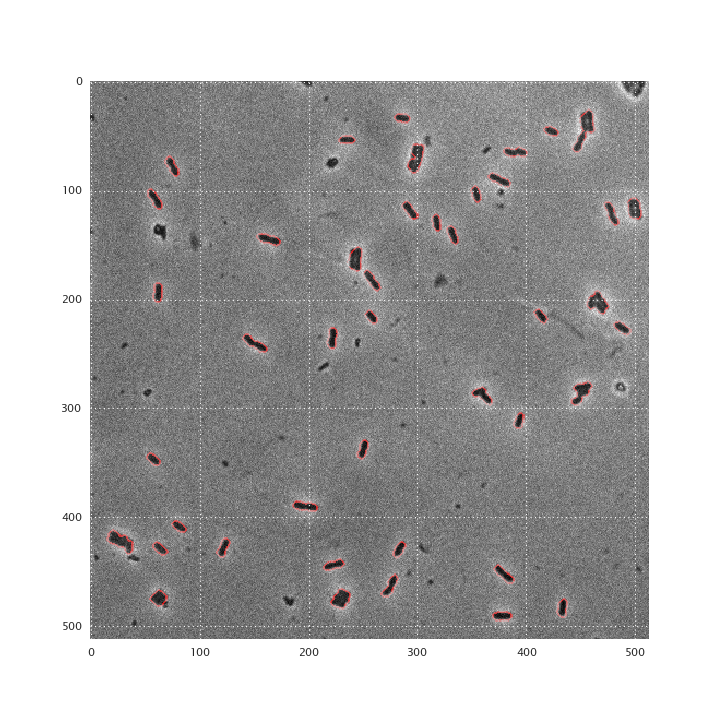

In [16]:
# LoG segment the mCherry channel of our example image.
rfp_seg = log_segmentation(rfp_im)

# Show the bounds of the segmentation.
bounds = skimage.segmentation.find_boundaries(rfp_seg)

# Make a merge of the segmentation mask.
phase_float = (phase - phase.min()) / (phase.max() - phase.min())
phase_float_copy = np.copy(phase_float)
phase_float_copy[bounds] = 0.8
merge = np.dstack((phase_float_copy, phase_float, phase_float))

# Show the merge of the segmentation mask.
plt.figure(figsize=(9, 9))
plt.imshow(merge, interpolation='nearest')

We see that this segmentation procedure functions quite nicely and faithfully identifies only bacterial objects. However, this fails in some ways when cells are very close to each other. We can remove these cells by filtering objects with respect to area and eccentricity.

### Extracting cell properties

Rather than spending more time on improving the segmentation algorithm, We can refine our cellular objects after segmentation by extracting area information as well as fluorescence intensity measurements. We define a function to perform measurement extraction below. 

In [17]:
def props_to_df(mask, physical_distance=1, intensity_image=None):
    """
    Converts the output of skimage.measure.regionprops to a nicely
    formatted pandas DataFrame.
    
    Parameters
    ----------
    mask : 2d-array, int
        Segmentation mask containing objects to be measured.
    physical_distance : int or float
        Interpixel distance of the image. This will be used to 
        convert the area measurements to meaningful units.
    intensity_image : 2d-array
        Intensity image for intensity based measurements. If none is 
        provided, only region based measurements will be returned.
        
    Returns
    -------
    df : pandas DataFrame
        Tidy DataFrame containing all measurements.
    
    """
    
    # Ensure that there is at least one object in the image. 
    if np.max(mask) == 0:
        raise ValueError('no objects found in image.')
        
    # Define the values that are to be extracted.
    REGIONPROPS = ('area', 'eccentricity', 'solidity',
                   'mean_intensity')
 
    if intensity_image is None:
        measurements = REGIONPROPS[:-3]
    else:
        measurements = REGIONPROPS
        
    # Iterate through and extract the props.
    props = skimage.measure.regionprops(mask,
                                        intensity_image=intensity_image)
    for i, p in enumerate(props):
        extracted = []
        for val in measurements:
            extracted.append(p[val])

        if i == 0:
            df = pd.DataFrame(extracted).T
        else:
            df2 = pd.DataFrame(extracted).T
            df = df.append(df2)
    df.columns = measurements
    df['area'] = df['area'] * physical_distance**2
    return df

We can now use this function to extract measurements from each cell and generate a tidy dataframe.

In [ ]:
# Define the names of the strains and IPTG concentrations.
strains = ['auto', 'delta', 'RBS1027']
iptg_range = [0, 0.1, 5, 10, 25, 50, 75, 
              100, 250, 500, 1000, 5000]
date = 20161018
username = 'gchure'
operator = 'O2'
binding_energy = -13.9
repressors = [0, 0, 130]
ip_dist = 0.160  # In units of µm per pixel

# Iterate through each strain and concentration to make the dataframes.
dfs = []
for i, st in enumerate(strains):
    for j, iptg in enumerate(iptg_range):
        # Load the images.  
        images = glob.glob(data_dir + '*' + st + '*_' + str(iptg) +
                            'uMIPTG*/*.ome.tif')
        ims = skimage.io.ImageCollection(images)
        for _, x in enumerate(ims):
            _, m, y = ome_split(x)
            y_flat = generate_flatfield(y, average_dark, average_field)
            
            # Segment the mCherry channel.
            m_seg = log_segmentation(m, label=True)
            
            # Extract the measurements.
            im_df = props_to_df(m_seg, physical_distance=ip_dist,
                                intensity_image=y_flat)
            
            # Add strain and  IPTG concentration information.
            im_df.insert(0, 'IPTG_uM', iptg)
            im_df.insert(0, 'repressors', repressors[i])
            im_df.insert(0, 'rbs', st)
            im_df.insert(0, 'binding_energy', binding_energy)
            im_df.insert(0, 'operator', operator)
            im_df.insert(0, 'username', username)
            im_df.insert(0, 'date', date)
            
            # Append the dataframe to the global list.
            dfs.append(im_df)
            
# Concatenate the dataframe
final_df = pd.concat(dfs, axis=0)

/Users/gchure/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:103: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [ ]:
def ecdf(data):
    """
    Computes the empirical cumulative distribution function (ECDF)
    of a given set of 1D data.
    
    Parameters
    ----------
    data : 1d-array
        Data from which the ECDF will be computed.
    
    Returns
    -------
    x, y : 1d-arrays
        The sorted data (x) and the ECDF (y) of the data.
    """
    
    return np.sort(data), np.arange(len(data))/len(data)


In [ ]:
# Look at the size distribution.
area_x,area_cdf = ecdf(final_df['area'])
plt.figure()
plt.plot(area_x, area_cdf, '.')
plt.xlabel('area (µm$^2$)')
plt.ylabel('ECDF')
plt.margins(0.02)

In [34]:
final_df

,date,username,operator,binding_energy,rbs,repressors,IPTG_uM,area,eccentricity,solidity,mean_intensity
0,20161018,gchure,O2,-13.9,auto,0,0.0,99.0,0.836521,0.942857,134.154620
0,20161018,gchure,O2,-13.9,auto,0,0.0,106.0,0.882338,0.921739,118.181348
0,20161018,gchure,O2,-13.9,auto,0,0.0,171.0,0.946937,0.872449,120.647971
0,20161018,gchure,O2,-13.9,auto,0,0.0,220.0,0.831335,0.956522,122.134728
0,20161018,gchure,O2,-13.9,auto,0,0.0,111.0,0.878814,0.948718,113.355678
0,20161018,gchure,O2,-13.9,auto,0,0.0,91.0,0.849031,0.978495,113.415954
0,20161018,gchure,O2,-13.9,auto,0,0.0,127.0,0.658197,0.962121,113.906742
0,20161018,gchure,O2,-13.9,auto,0,0.0,77.0,0.727672,0.987179,105.016235
0,20161018,gchure,O2,-13.9,auto,0,0.0,97.0,0.852871,0.979798,99.630374
0,20161018,gchure,O2,-13.9,auto,0,0.0,94.0,0.801476,0.959184,115.240052


In [21]:
images

['/Users/gchure/Desktop/20161018/20161018_wt_O2_RBS1027_5000uMIPTG_1/20161018_wt_O2_RBS1027_5000uMIPTG_1_MMStack_Pos0.ome.tif',
 '/Users/gchure/Desktop/20161018/20161018_wt_O2_RBS1027_5000uMIPTG_10/20161018_wt_O2_RBS1027_5000uMIPTG_10_MMStack_Pos0.ome.tif',
 '/Users/gchure/Desktop/20161018/20161018_wt_O2_RBS1027_5000uMIPTG_11/20161018_wt_O2_RBS1027_5000uMIPTG_11_MMStack_Pos0.ome.tif',
 '/Users/gchure/Desktop/20161018/20161018_wt_O2_RBS1027_5000uMIPTG_12/20161018_wt_O2_RBS1027_5000uMIPTG_12_MMStack_Pos0.ome.tif',
 '/Users/gchure/Desktop/20161018/20161018_wt_O2_RBS1027_5000uMIPTG_13/20161018_wt_O2_RBS1027_5000uMIPTG_13_MMStack_Pos0.ome.tif',
 '/Users/gchure/Desktop/20161018/20161018_wt_O2_RBS1027_5000uMIPTG_14/20161018_wt_O2_RBS1027_5000uMIPTG_14_MMStack_Pos0.ome.tif',
 '/Users/gchure/Desktop/20161018/20161018_wt_O2_RBS1027_5000uMIPTG_15/20161018_wt_O2_RBS1027_5000uMIPTG_15_MMStack_Pos0.ome.tif',
 '/Users/gchure/Desktop/20161018/20161018_wt_O2_RBS1027_5000uMIPTG_16/20161018_wt_O2_RBS1027

In [ ]:
for i in dfs:
    print(len(i))

In [23]:
grouped = final_df.groupby(['IPTG_uM', 'rbs']).unique()
grouped

AttributeError: 'DataFrameGroupBy' object has no attribute 'unique'

In [ ]:
! open ../../data/microscopy/
